In [3]:
import pandas as pd
import string
import re
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = 'marathi.csv'  # Update with correct path
data = pd.read_csv(file_path)

# Define custom Gujarati stopwords (expand as needed)
marathi_stopwords = set(["आहे", "आहेस", "आहेत", "होते", "होतेस", "होतेत", "झालं", "झाली", "झाले", "हे", "तो", "ती", "ते", "या", "या", "मी", "आम्ही", "तू", "तुम्ही", "आम्हाला", "तुला", "तुम्हाला", "माझं", "तुझं", "तिचं", "त्याचं", "त्यांचं", "त्यांचा", "तिचा", "तिचं", "त्यात", "त्यावर", "त्याच्या", "यांच्या", "हा", "ह्या", "त्या", "मी", "आम्हाला", "आहे", "होते", "नाही", "कधी", "कुठे", "का", "जेव्हा", "जे", "कोण", "कसा", "कसे", "किती", "इथे", "तिथे", "आता", "पुन्हा", "म्हणून", "किंवा", "पण", "मात्र", "म्हणूनच", "जर", "तर", "आणि", "बरोबर", "नाहीतर", "शक्यतो", "सगळे", "संपूर्ण", "काही", "कोणता", "कोणती", "कोणते", "काय", "कुठला", "कुठेही", "कुणीही", "काहीच", "काहीही", "सर्व", "तसेच", "म्हणूनच", "आता", "पुढे", "मागे", "नेहमी", "थोडा", "खूप", "मोठा", "छोटा", "साधारण", "पूर्ण", "नंतर"
])  # Add relevant Gujarati stopwords

# Function for text normalization and stopword removal
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'[^\u0900-\u097F ]', '', text)  # Keep only Marathi (Devanagari) characters
    text = ' '.join([word for word in text.split() if word not in marathi_stopwords])  # Remove stopwords
    return text

# Apply preprocessing to normalize text and remove stopwords
data['Processed_Sentence'] = data['Sentence'].apply(preprocess_text)

# Filter sentences based on length (e.g., between 5 and 50 words)
min_length = 5
max_length = 50

def filter_sentence_length(text):
    word_count = len(text.split())
    return min_length <= word_count <= max_length

data = data[data['Processed_Sentence'].apply(filter_sentence_length)]

# Encode the Sentiment and Emotion columns
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

data['Sentiment_Label'] = sentiment_encoder.fit_transform(data['Sentiment'])
data['Emotion_Label'] = emotion_encoder.fit_transform(data['Emotion'])


<ipython-input-3-c2a8355e2572>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Sentiment_Label'] = sentiment_encoder.fit_transform(data['Sentiment'])
<ipython-input-3-c2a8355e2572>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Emotion_Label'] = emotion_encoder.fit_transform(data['Emotion'])


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Splitting the data for Sentiment prediction
X = data['Processed_Sentence']
y_sentiment = data['Sentiment_Label']

X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(X, y_sentiment, test_size=0.2, random_state=42)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, and transform the test data
X_train_tfidf_sentiment = tfidf_vectorizer.fit_transform(X_train_sentiment)
X_test_tfidf_sentiment = tfidf_vectorizer.transform(X_test_sentiment)


In [5]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes model
nb_sentiment = MultinomialNB()

# Train the model
nb_sentiment.fit(X_train_tfidf_sentiment, y_train_sentiment)

# Make predictions on test data
y_pred_sentiment = nb_sentiment.predict(X_test_tfidf_sentiment)

# Evaluate the model
accuracy_sentiment = accuracy_score(y_test_sentiment, y_pred_sentiment)
classification_report_sentiment = classification_report(y_test_sentiment, y_pred_sentiment, target_names=sentiment_encoder.classes_)
confusion_matrix_sentiment = confusion_matrix(y_test_sentiment, y_pred_sentiment)

# Display evaluation results for Sentiment
print("Sentiment Prediction Accuracy:", accuracy_sentiment)
print("Classification Report:\n", classification_report_sentiment)
print("Confusion Matrix:\n", confusion_matrix_sentiment)


Sentiment Prediction Accuracy: 0.9044823303601671
Classification Report:
               precision    recall  f1-score   support

    Negative       0.94      0.92      0.93     12227
     Neutral       0.88      0.91      0.89     11933
    Positive       0.89      0.88      0.89     11268

    accuracy                           0.90     35428
   macro avg       0.90      0.90      0.90     35428
weighted avg       0.90      0.90      0.90     35428

Confusion Matrix:
 [[11292   511   424]
 [  365 10809   759]
 [  353   972  9943]]


In [6]:
# Splitting the data for Emotion prediction
y_emotion = data['Emotion_Label']

X_train_emotion, X_test_emotion, y_train_emotion, y_test_emotion = train_test_split(X, y_emotion, test_size=0.2, random_state=42)

# TF-IDF Vectorization for Emotion
X_train_tfidf_emotion = tfidf_vectorizer.fit_transform(X_train_emotion)
X_test_tfidf_emotion = tfidf_vectorizer.transform(X_test_emotion)

# Initialize Naive Bayes for Emotion prediction
nb_emotion = MultinomialNB()

# Train the model
nb_emotion.fit(X_train_tfidf_emotion, y_train_emotion)

# Make predictions on test data
y_pred_emotion = nb_emotion.predict(X_test_tfidf_emotion)

# Evaluate the model
accuracy_emotion = accuracy_score(y_test_emotion, y_pred_emotion)
classification_report_emotion = classification_report(y_test_emotion, y_pred_emotion, target_names=emotion_encoder.classes_)
confusion_matrix_emotion = confusion_matrix(y_test_emotion, y_pred_emotion)

# Display evaluation results for Emotion
print("Emotion Prediction Accuracy:", accuracy_emotion)
print("Classification Report:\n", classification_report_emotion)
print("Confusion Matrix:\n", confusion_matrix_emotion)


Emotion Prediction Accuracy: 0.8147792706333973
Classification Report:
               precision    recall  f1-score   support

  Acceptance       0.85      0.88      0.86      3976
       Anger       0.95      0.96      0.95      4224
        Calm       0.84      0.81      0.82      3648
       Grief       0.56      0.56      0.56      4029
        Hope       0.84      0.89      0.87      3957
         Joy       0.90      0.83      0.86      3589
        Love       0.92      0.97      0.94      3722
       Peace       0.88      0.95      0.91      4309
     Sadness       0.57      0.49      0.53      3974

    accuracy                           0.81     35428
   macro avg       0.81      0.81      0.81     35428
weighted avg       0.81      0.81      0.81     35428

Confusion Matrix:
 [[3486   28  100   38  122   35   81   72   14]
 [  19 4039   31   20   32   29   12   19   23]
 [ 117   37 2960   43  167   89   43  155   37]
 [ 100   45   70 2247   93   35   51   75 1313]
 [  82   17 

In [7]:
import joblib

# Save the sentiment and emotion models
joblib.dump(nb_sentiment, 'sentiment_model.pkl')
joblib.dump(nb_emotion, 'emotion_model.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')


['tfidf_vectorizer.pkl']

In [8]:
# Custom sentences for testing
custom_sentences = ["तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे",
"तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय",
"सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं",
"शांततेत बसून वाऱ्याच्या हळुवार स्पर्शात विश्वाचं गूढ हळूहळू उलगडत जातं",
"तुझ्या सहवासात प्रत्येक क्षणाचं अनमोल महत्त्व उमजतं, आणि जग सुंदर भासतं"
]

# English translations of the custom sentences
english_translations = ["Your bitter words have only intensified the smoldering fire within me",
"Your departure in this manner makes it feel like each day grows dimmer and dimmer",
"When the truth came forward, it felt like all dreams shattered, yet the journey must continue",
"Sitting quietly and feeling the gentle touch of the wind, the mysteries of the universe slowly unfold",
"Every moment with you feels precious, and the world seems beautiful in your presence"

]

# Preprocess the custom sentences
custom_processed_sentences = [preprocess_text(sentence) for sentence in custom_sentences]

# Transform the custom sentences using the fitted TF-IDF vectorizer
custom_tfidf = tfidf_vectorizer.transform(custom_processed_sentences)

# Predict sentiment for custom sentences
custom_sentiment_predictions = nb_sentiment.predict(custom_tfidf)
custom_sentiment_labels = sentiment_encoder.inverse_transform(custom_sentiment_predictions)

# Predict emotion for custom sentences
custom_emotion_predictions = nb_emotion.predict(custom_tfidf)
custom_emotion_labels = emotion_encoder.inverse_transform(custom_emotion_predictions)

# Display the custom sentences with their predicted sentiment, emotion, and English translations
for i, sentence in enumerate(custom_sentences):
    print(f"Gujarati Sentence: {sentence}")
    print(f"English Translation: {english_translations[i]}")
    print(f"Predicted Sentiment: {custom_sentiment_labels[i]}")
    print(f"Predicted Emotion: {custom_emotion_labels[i]}")
    print("-" * 50)


Gujarati Sentence: तुझ्या कटू शब्दांनी मनात धगधगणारा अंगार अजून तीव्र होत चालला आहे
English Translation: Your bitter words have only intensified the smoldering fire within me
Predicted Sentiment: Negative
Predicted Emotion: Joy
--------------------------------------------------
Gujarati Sentence: तुझं अशा रीतीने दूर जाणं जणू प्रत्येक दिवस थोडा थोडा कमी उजेडाचा होत जातोय
English Translation: Your departure in this manner makes it feel like each day grows dimmer and dimmer
Predicted Sentiment: Negative
Predicted Emotion: Sadness
--------------------------------------------------
Gujarati Sentence: सत्य समोर आलं तेव्हा सगळ्या स्वप्नांचा चुराडा झाल्याचं जाणवलं, पण तरीही चालावं लागतं
English Translation: When the truth came forward, it felt like all dreams shattered, yet the journey must continue
Predicted Sentiment: Neutral
Predicted Emotion: Acceptance
--------------------------------------------------
Gujarati Sentence: शांततेत बसून वाऱ्याच्या हळुवार स्पर्शात विश्वाचं गूढ हळूहळू उलगडत जा

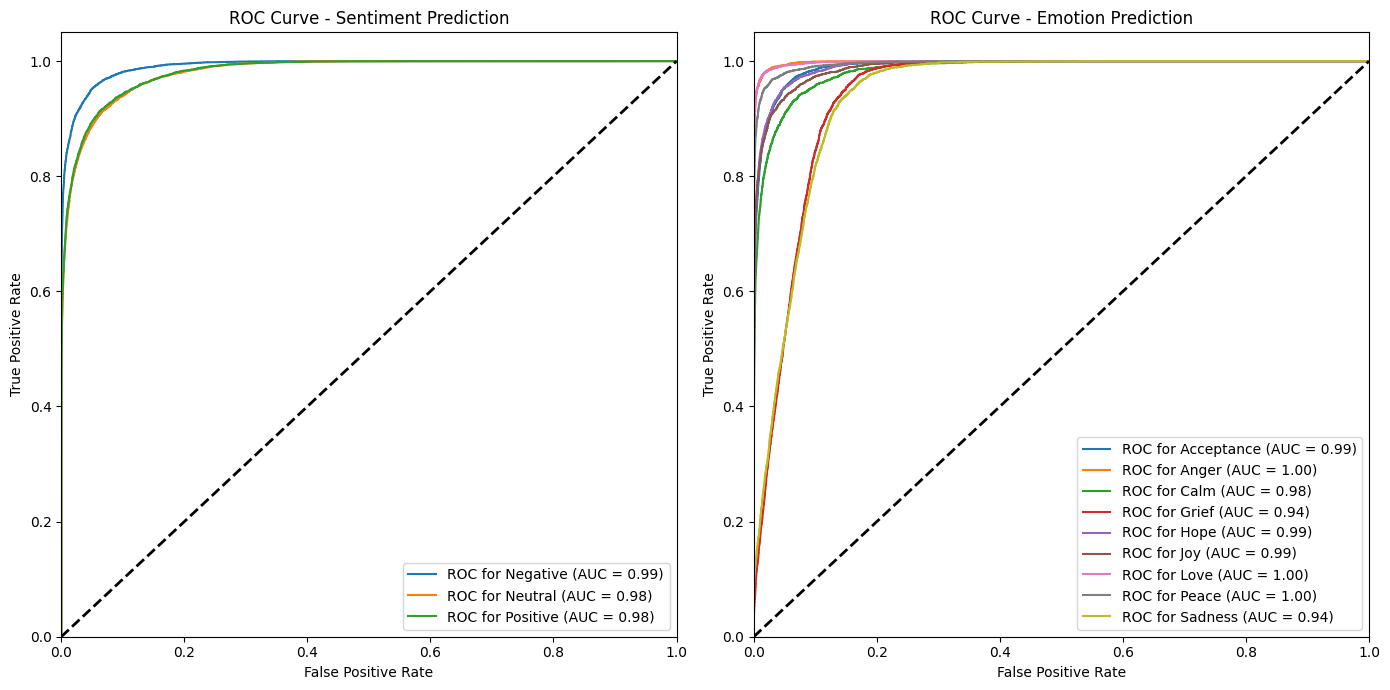

In [10]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder

# Load the saved models and TF-IDF vectorizer
nb_sentiment = joblib.load('sentiment_model.pkl')
nb_emotion = joblib.load('emotion_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load your dataset to refit the LabelEncoder with actual classes
file_path = 'marathi.csv'  # Update with the correct file path
data = pd.read_csv(file_path)

# Re-fit the LabelEncoder for both sentiment and emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

sentiment_encoder.fit(data['Sentiment'])  # Fit using the actual classes from the dataset
emotion_encoder.fit(data['Emotion'])

# Assuming the test set is already available
# X_test_sentiment, y_test_sentiment, X_test_emotion, y_test_emotion

# Transform the test data using the TF-IDF vectorizer
X_test_tfidf_sentiment = tfidf_vectorizer.transform(X_test_sentiment)
X_test_tfidf_emotion = tfidf_vectorizer.transform(X_test_emotion)

# Get the predicted probabilities for sentiment and emotion
y_prob_sentiment = nb_sentiment.predict_proba(X_test_tfidf_sentiment)
y_prob_emotion = nb_emotion.predict_proba(X_test_tfidf_emotion)

# Binarize the true labels for multi-class ROC/AUC
y_test_sentiment_binarized = label_binarize(y_test_sentiment, classes=np.arange(len(sentiment_encoder.classes_)))
y_test_emotion_binarized = label_binarize(y_test_emotion, classes=np.arange(len(emotion_encoder.classes_)))

# Calculate ROC curves and AUC for each class (sentiment)
fpr_sentiment = dict()
tpr_sentiment = dict()
roc_auc_sentiment = dict()

for i in range(len(sentiment_encoder.classes_)):
    fpr_sentiment[i], tpr_sentiment[i], _ = roc_curve(y_test_sentiment_binarized[:, i], y_prob_sentiment[:, i])
    roc_auc_sentiment[i] = auc(fpr_sentiment[i], tpr_sentiment[i])

# Plot ROC curves for each sentiment class
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
for i in range(len(sentiment_encoder.classes_)):
    plt.plot(fpr_sentiment[i], tpr_sentiment[i], label=f'ROC for {sentiment_encoder.classes_[i]} (AUC = {roc_auc_sentiment[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Sentiment Prediction')
plt.legend(loc="lower right")

# Calculate ROC curves and AUC for each class (emotion)
fpr_emotion = dict()
tpr_emotion = dict()
roc_auc_emotion = dict()

for i in range(len(emotion_encoder.classes_)):
    fpr_emotion[i], tpr_emotion[i], _ = roc_curve(y_test_emotion_binarized[:, i], y_prob_emotion[:, i])
    roc_auc_emotion[i] = auc(fpr_emotion[i], tpr_emotion[i])

# Plot ROC curves for each emotion class
plt.subplot(1, 2, 2)
for i in range(len(emotion_encoder.classes_)):
    plt.plot(fpr_emotion[i], tpr_emotion[i], label=f'ROC for {emotion_encoder.classes_[i]} (AUC = {roc_auc_emotion[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Emotion Prediction')
plt.legend(loc="lower right")

# Show the plots
plt.tight_layout()
plt.show()


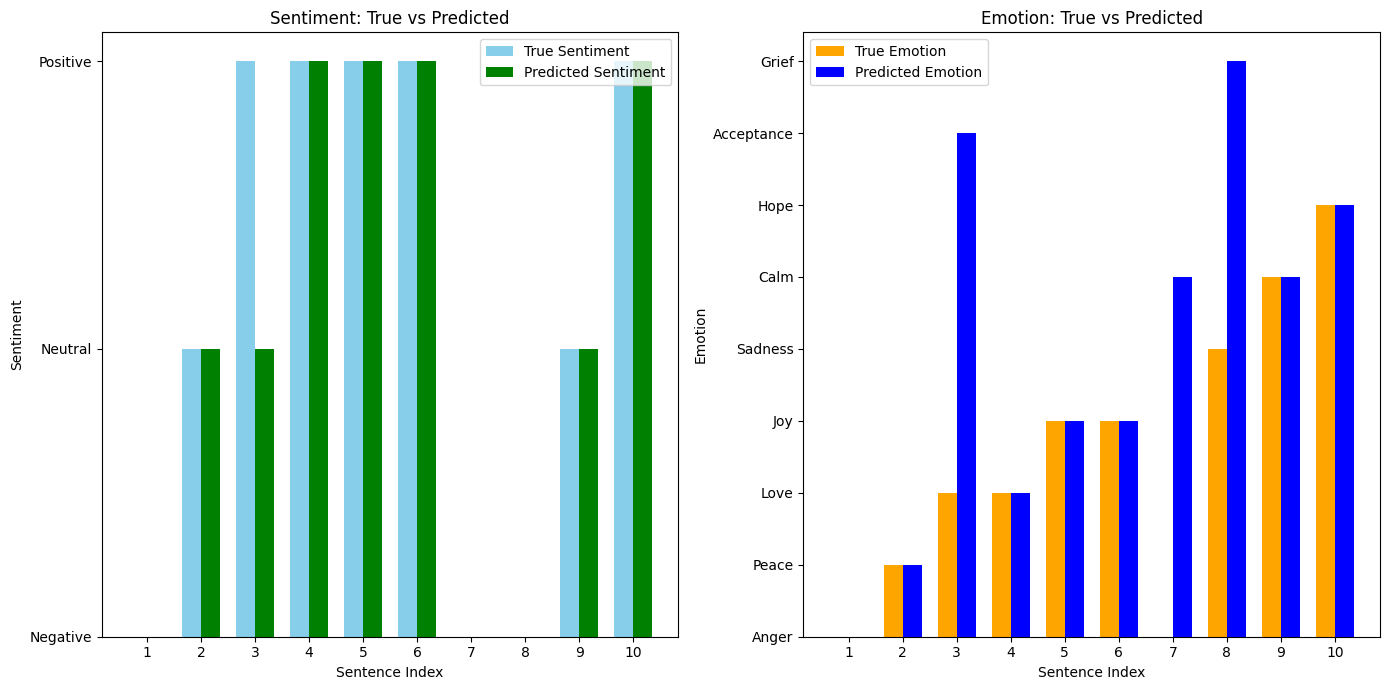

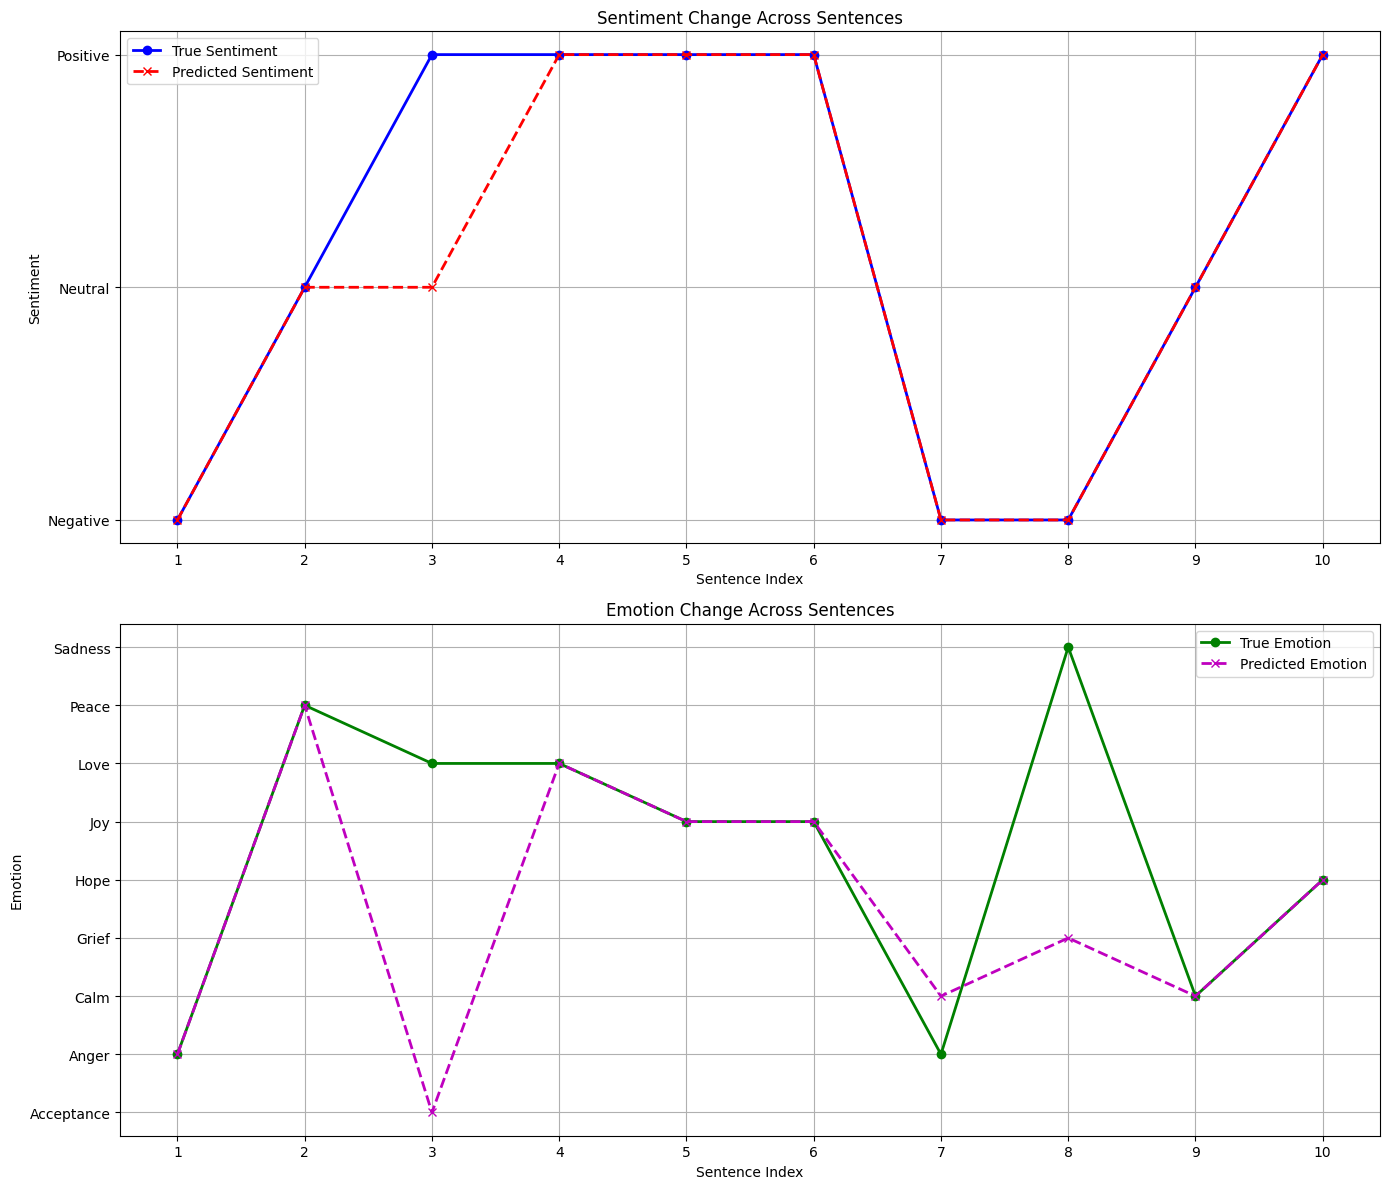

In [12]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Load the saved models and TF-IDF vectorizer
nb_sentiment = joblib.load('sentiment_model.pkl')
nb_emotion = joblib.load('emotion_model.pkl')
tfidf_vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load the dataset
file_path = 'marathi.csv'  # Update with correct path
data = pd.read_csv(file_path)

# Re-fit the LabelEncoder for both sentiment and emotion
sentiment_encoder = LabelEncoder()
emotion_encoder = LabelEncoder()

sentiment_encoder.fit(data['Sentiment'])  # Fit using actual classes from the dataset
emotion_encoder.fit(data['Emotion'])

# Randomly select 10 sentences from the dataset for testing
sample_data = data.sample(n=10, random_state=42)
sample_sentences = sample_data['Sentence'].tolist()
sample_true_sentiments = sample_data['Sentiment'].tolist()
sample_true_emotions = sample_data['Emotion'].tolist()

# Preprocess the selected sentences
def preprocess_text(text):
    # Add your preprocessing steps (lowercase, punctuation removal, etc.)
    return text.lower()

sample_processed_sentences = [preprocess_text(sentence) for sentence in sample_sentences]

# Transform the selected sentences using the TF-IDF vectorizer
sample_tfidf = tfidf_vectorizer.transform(sample_processed_sentences)

# Predict sentiment and emotion for the sample sentences
pred_sentiment = nb_sentiment.predict(sample_tfidf)
pred_emotion = nb_emotion.predict(sample_tfidf)

# Decode predicted labels
predicted_sentiment_labels = sentiment_encoder.inverse_transform(pred_sentiment)
predicted_emotion_labels = emotion_encoder.inverse_transform(pred_emotion)

# Plotting Bar Plot: True vs Predicted Sentiment
plt.figure(figsize=(14, 7))

# Sentiment Bar Plot
plt.subplot(1, 2, 1)
x = np.arange(len(sample_sentences))  # Label locations
bar_width = 0.35  # Width of the bars

# Plot bars for true sentiment
plt.bar(x - bar_width/2, sample_true_sentiments, width=bar_width, color='skyblue', label='True Sentiment')

# Plot bars for predicted sentiment
plt.bar(x + bar_width/2, predicted_sentiment_labels, width=bar_width, color='green', label='Predicted Sentiment')

# Label the plot
plt.title('Sentiment: True vs Predicted')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Plotting Bar Plot: True vs Predicted Emotion
plt.subplot(1, 2, 2)
x = np.arange(len(sample_sentences))  # Label locations

# Plot bars for true emotion
plt.bar(x - bar_width/2, sample_true_emotions, width=bar_width, color='orange', label='True Emotion')

# Plot bars for predicted emotion
plt.bar(x + bar_width/2, predicted_emotion_labels, width=bar_width, color='blue', label='Predicted Emotion')

# Label the plot
plt.title('Emotion: True vs Predicted')
plt.xlabel('Sentence Index')
plt.ylabel('Emotion')
plt.xticks(x, range(1, len(sample_sentences) + 1))
plt.legend()

# Show bar plots
plt.tight_layout()
plt.show()

# Line Graph for Sentiment and Emotion Predictions

# Map sentiment and emotion labels to indices for plotting
sentiment_index = {label: idx for idx, label in enumerate(sentiment_encoder.classes_)}
emotion_index = {label: idx for idx, label in enumerate(emotion_encoder.classes_)}

# Convert label names to indices for plotting
true_sentiment_indices = [sentiment_index[label] for label in sample_true_sentiments]
predicted_sentiment_indices = [sentiment_index[label] for label in predicted_sentiment_labels]

true_emotion_indices = [emotion_index[label] for label in sample_true_emotions]
predicted_emotion_indices = [emotion_index[label] for label in predicted_emotion_labels]

# Create line plots
plt.figure(figsize=(14, 12))

# Plot Sentiment
plt.subplot(2, 1, 1)
plt.plot(range(len(sample_sentences)), true_sentiment_indices, marker='o', linestyle='-', color='b', label='True Sentiment', linewidth=2)
plt.plot(range(len(sample_sentences)), predicted_sentiment_indices, marker='x', linestyle='--', color='r', label='Predicted Sentiment', linewidth=2)
plt.title('Sentiment Change Across Sentences')
plt.xlabel('Sentence Index')
plt.ylabel('Sentiment')
plt.yticks(ticks=range(len(sentiment_encoder.classes_)), labels=sentiment_encoder.classes_)
plt.xticks(range(len(sample_sentences)), range(1, len(sample_sentences) + 1))
plt.legend()
plt.grid(True)

# Plot Emotion
plt.subplot(2, 1, 2)
plt.plot(range(len(sample_sentences)), true_emotion_indices, marker='o', linestyle='-', color='g', label='True Emotion', linewidth=2)
plt.plot(range(len(sample_sentences)), predicted_emotion_indices, marker='x', linestyle='--', color='m', label='Predicted Emotion', linewidth=2)
plt.title('Emotion Change Across Sentences')
plt.xlabel('Sentence Index')
plt.ylabel('Emotion')
plt.yticks(ticks=range(len(emotion_encoder.classes_)), labels=emotion_encoder.classes_)
plt.xticks(range(len(sample_sentences)), range(1, len(sample_sentences) + 1))
plt.legend()
plt.grid(True)

# Show the line graphs
plt.tight_layout()
plt.show()
